<a href="https://colab.research.google.com/github/zhaolotelli/FedLearn/blob/main/AFL_for_Fashion_MNIST_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import packages and datasets

In [ ]:
import numpy as np
import pandas as pd
import collections
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch import nn, optim
from torch.utils.data import TensorDataset, DataLoader, BatchSampler, RandomSampler

In [ ]:
train_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = True, download = True, transform = transforms.ToTensor())
test_dataset = torchvision.datasets.FashionMNIST(root = "./data", train = False, download = True, transform = transforms.ToTensor())


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw




Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Processing...


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


Done!


In [ ]:
raw_X = train_dataset.data.to(dtype = torch.float32)
mu = raw_X.mean(dim = 0)
sigma = raw_X.std(dim = 0)

In [ ]:
IDs = list(train_dataset.class_to_idx.keys())
ID2idx = train_dataset.class_to_idx

In [ ]:
IDs = ['Shirt', 'Pullover', 'T-shirt/top']
ID2idx = {'Shirt': 0,
      'Pullover': 1,
      'T-shirt/top': 2}

In [ ]:
class Client_Data(object):
  def __init__(self, dataset, id):
    data = dataset.data
    targets = dataset.targets
    idx = dataset.class_to_idx[id]
    new_idx = ID2idx[id]
    idx_diff = new_idx - idx
    raw_X = data[dataset.targets == idx].to(dtype = torch.float32)
    #mu = raw_X.mean(dim = 0)
    #sigma = raw_X.std(dim = 0)
    self.X = (raw_X - mu) / (sigma + 0.001)
    self.y = targets[dataset.targets == idx] + idx_diff

  def __len__(self):
    return len(self.y)

In [ ]:
class Client_Data(object):
  def __init__(self, dataset, id):
    data = dataset.data
    targets = dataset.targets
    idx = dataset.class_to_idx[id]
    new_idx = ID2idx[id]
    idx_diff = new_idx - idx
    raw_X = data[dataset.targets == idx].to(dtype = torch.float32)
    #mu = raw_X.mean(dim = 0)
    #sigma = raw_X.std(dim = 0)
    self.X = (raw_X - mu) / 500
    self.y = targets[dataset.targets == idx] + idx_diff

  def __len__(self):
    return len(self.y)

## Define Clients and Servers

In [ ]:
class Client(object):
  def __init__(self, id, client_data):
    self.id = id
    self.client_data = client_data

  def create_model(self, Learner, initial_params, learning_rate):
    self.model = Learner(initial_params, learning_rate)

  def update_model(self, params):
    self.model.assign_params(params)

  def train(self, epoch, batch_size):
    self.model.train(self.client_data, epoch, batch_size)
    loss = self.model.solve_loss(self.client_data)
    num_example = len(self.client_data)
    return num_example, loss

  def sgd(self, batch_size):
    loss, grads = self.model.sgd(self.client_data, batch_size)
    num_example = len(self.client_data)
    return num_example, loss, grads

In [ ]:
class Server(object):
  def __init__(self, train_data, ids, Learner, initial_params, learning_rate):
    self.ids = ids
    self.learner = Learner
    self.clients = self.set_clients(train_data)
    self.model = self.learner(initial_params, learning_rate)

  def set_clients(self, train_data):
    clients = []
    for id in self.ids:
      client_data = Client_Data(train_data, id)
      c = Client(id, client_data)
      c.create_model(self.learner, initial_params, learning_rate)
      clients.append(c)
    return clients

  def send_model(self):
    params = self.model.print_params()
    for c in self.clients:
      c.update_model(params)

  def select_client(self, select_rate):
    self.num_clients = np.maximum(1, np.int(np.floor(len(self.ids) * select_rate)))
    select_ids = np.random.choice(self.ids, self.num_clients, replace=False)
    select_clients = []
    for id in select_ids:
      loc_id = np.array([id == idx for idx in self.ids])
      ind = np.int(np.array(range(len(self.ids)))[loc_id])
      select_client = self.clients[ind]
      select_clients.append(select_client)
    return select_clients

## Define Training model

Logistic Regression Model

In [ ]:
dev = torch.device(
    "cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
dev

device(type='cpu')

In [ ]:
INPUT_SIZE = 784
OUTPUT_SIZE = 3

In [ ]:
class my_LogR(nn.Module):
  def __init__(self, initial_params, learning_rate):
    super().__init__()

    self.lr = learning_rate
    self.loss_fn = nn.CrossEntropyLoss()

    self.linear = nn.Linear(INPUT_SIZE, OUTPUT_SIZE)

    if initial_params is not None:
      self.assign_params(initial_params)

  def forward(self, xb):
    xb = xb.view(-1, INPUT_SIZE)
    logits = self.linear(xb)
    return logits

  def train(self, client_data, epoch, batch_size):
    # X, y = map(torch.tensor, (client_data.X, client_data.y))
    X, y = (client_data.X, client_data.y)
    if dev == torch.device("cuda"):
      X = X.to(dev)
      y = y.to(dev)
      self.linear.to(dev)
    train_ds = TensorDataset(X, y)
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
    opt = optim.Adam(self.parameters(), lr=self.lr, weight_decay=0.001)
    #opt = optim.SGD(self.parameters(), lr = self.lr)

    for _ in range(epoch):
      for xb, yb in train_dl:
        logits = self.forward(xb)
        loss = self.loss_fn(logits, yb)
        #loss_value = loss.item()

        loss.backward()
        opt.step()
        opt.zero_grad()

        # print('loss: {}'.format(loss_value))

  def sgd(self, client_data, batch_size):
    # X, y = map(torch.tensor, (client_data.X, client_data.y))
    X, y = (client_data.X, client_data.y)
    if dev == torch.device("cuda"):
      X = X.to(dev)
      y = y.to(dev)
      self.linear.to(dev)
    train_ds = TensorDataset(X, y)
    train_dl = DataLoader(train_ds, 
        sampler = BatchSampler(RandomSampler(train_ds), 
        batch_size = batch_size, drop_last = False
    ))
    xb, yb = next(iter(train_dl))
    xb = xb.view(-1, INPUT_SIZE)
    yb = yb.view(-1)
    
    opt = optim.Adam(self.parameters(), lr=self.lr, weight_decay=0.001)
    
    logits = self.forward(xb)
    loss = self.loss_fn(logits, yb)
      
    loss.backward()
    grads = []
    if dev == torch.device("cuda"):
      grads.append(self.linear.weight.grad.view(-1).cpu().detach().numpy())
      grads.append(self.linear.bias.grad.cpu().detach().numpy())
    else:
      grads.append(self.linear.weight.grad.view(-1).detach().numpy())
      grads.append(self.linear.bias.grad.detach().numpy())    


    #opt.step()
    #opt.zero_grad()
    
    loss_value = self.solve_loss(client_data)

    return loss_value, grads

  def assign_params(self, params):
    self.linear.weight = nn.Parameter(torch.tensor(params[0].reshape(OUTPUT_SIZE, INPUT_SIZE), dtype=torch.float32))
    self.linear.bias = nn.Parameter(torch.tensor(params[1], dtype=torch.float32))

  def print_params(self):
    if dev == torch.device("cuda"):
      params = [self.linear.weight.cpu().detach().numpy().reshape(-1),
            self.linear.bias.cpu().detach().numpy()]
    else:
      params = [self.linear.weight.detach().numpy().reshape(-1),
            self.linear.bias.detach().numpy()]
    return params
  
  def solve_loss(self, client_data):
    # X = torch.tensor(client_data.X)
    X = client_data.X
    # y_true = torch.tensor(client_data.y)
    y_true = client_data.y
    if dev == torch.device("cuda"):
      X = X.to(dev)
      y_true = y_true.to(dev)
      self.linear.to(dev)

    y_pred = self.forward(X)
    return self.loss_fn(y_pred, y_true).item()

  def predict_accu(self, client_data):
    # X = torch.tensor(client_data.X)
    X = client_data.X
    # y_true = torch.tensor(client_data.y)
    y_true = client_data.y.detach().numpy()

    # y_pred = F.softmax(self.model(X), dim = 1).detach().numpy().argmax(axis = 1)

    if dev == torch.device("cuda"):
      X = X.to(dev)
      self.linear.to(dev)
      y_pred = F.softmax(self.forward(X), dim = 1).cpu().detach().numpy().argmax(axis = 1)
    else:
      y_pred = F.softmax(self.forward(X), dim = 1).detach().numpy().argmax(axis = 1)
    
    accuracy = sum(y_pred == y_true) / len(client_data)
    return accuracy

old version

In [ ]:
class my_LogR(object):
  def __init__(self, initial_params, learning_rate, 
               input_size = INPUT_SIZE, output_size = OUTPUT_SIZE):
    self.input_size = input_size
    self.output_size = output_size

    self.lr = learning_rate
    self.loss_fn = nn.CrossEntropyLoss()

    self.linear = nn.Linear(input_size, output_size)

    if initial_params is not None:
      self.assign_params(initial_params)

  def model(self, xb):
    xb = xb.view(-1, self.input_size)
    logits = self.linear(xb)
    return logits

  def train(self, client_data, epoch, batch_size):
    # X, y = map(torch.tensor, (client_data.X, client_data.y))
    X, y = (client_data.X, client_data.y)
    if dev == torch.device("cuda"):
      X = X.to(dev)
      y = y.to(dev)
      self.linear.to(dev)
    train_ds = TensorDataset(X, y)
    train_dl = DataLoader(train_ds, batch_size = batch_size, shuffle = True)
    opt = optim.Adam((self.linear.weight, 
              self.linear.bias), lr=self.lr, weight_decay=0.001)

    for _ in range(epoch):
      for xb, yb in train_dl:
        logits = self.model(xb)
        loss = self.loss_fn(logits, yb)
        loss_value = loss.item()

        loss.backward()
        opt.step()
        opt.zero_grad()

        # print('loss: {}'.format(loss_value))

  def sgd(self, client_data, batch_size):
    # X, y = map(torch.tensor, (client_data.X, client_data.y))
    X, y = (client_data.X, client_data.y)
    if dev == torch.device("cuda"):
      X = X.to(dev)
      y = y.to(dev)
      self.linear.to(dev)
    train_ds = TensorDataset(X, y)
    train_dl = DataLoader(train_ds, 
        sampler = BatchSampler(RandomSampler(train_ds), 
        batch_size = batch_size, drop_last = False
    ))
    xb, yb = next(iter(train_dl))
    xb = xb.view(-1, self.input_size)
    yb = yb.view(-1)
    
    opt = optim.Adam((self.linear.weight, 
              self.linear.bias), lr=self.lr, weight_decay=0.001)
    
    logits = self.model(xb)
    loss = self.loss_fn(logits, yb)
      
    loss.backward()
    grads = []
    if dev == torch.device("cuda"):
      grads.append(self.linear.weight.grad.view(-1).cpu().detach().numpy())
      grads.append(self.linear.bias.grad.cpu().detach().numpy())
    else:
      grads.append(self.linear.weight.grad.view(-1).detach().numpy())
      grads.append(self.linear.bias.grad.detach().numpy())    


    #opt.step()
    #opt.zero_grad()
    
    loss_value = self.solve_loss(client_data)

    return loss_value, grads

  def assign_params(self, params):
    self.linear.weight = nn.Parameter(torch.tensor(params[0].reshape(self.output_size, self.input_size), dtype=torch.float32))
    self.linear.bias = nn.Parameter(torch.tensor(params[1], dtype=torch.float32))

  def print_params(self):
    if dev == torch.device("cuda"):
      params = [self.linear.weight.cpu().detach().numpy().reshape(-1),
            self.linear.bias.cpu().detach().numpy()]
    else:
      params = [self.linear.weight.detach().numpy().reshape(-1),
            self.linear.bias.detach().numpy()]
    return params
  
  def solve_loss(self, client_data):
    # X = torch.tensor(client_data.X)
    X = client_data.X
    # y_true = torch.tensor(client_data.y)
    y_true = client_data.y
    if dev == torch.device("cuda"):
      X = X.to(dev)
      y_true = y_true.to(dev)
      self.linear.to(dev)

    y_pred = self.model(X)
    return self.loss_fn(y_pred, y_true).item()

  def predict_error(self, client_data):
    # X = torch.tensor(client_data.X)
    X = client_data.X
    # y_true = torch.tensor(client_data.y)
    y_true = client_data.y.detach().numpy()

    # y_pred = F.softmax(self.model(X), dim = 1).detach().numpy().argmax(axis = 1)

    if dev == torch.device("cuda"):
      X = X.to(dev)
      self.linear.to(dev)
      y_pred = F.softmax(self.model(X), dim = 1).cpu().detach().numpy().argmax(axis = 1)
    else:
      y_pred = F.softmax(self.model(X), dim = 1).detach().numpy().argmax(axis = 1)
    
    accuracy = sum(y_pred == y_true) / len(client_data)
    return accuracy

## Aggregation

FedAvg

In [ ]:
class WAVGM(Server):
  def __init__(self, train_data, ids, Learner, initial_params, learning_rate):
    super(WAVGM, self).__init__(train_data, ids, Learner, initial_params, learning_rate)

  def train(self, epoch, batch_size, sub_size = None, select_rate=1):
    self.send_model()
    self.select_clients = self.select_client(select_rate)
    losses = []
    self.client_nums = []
    for client in self.select_clients:
      client_num, client_loss = client.train(epoch, batch_size)
      losses.append(client_loss)
      self.client_nums.append(client_num)
      # print('Client: {}, Local_loss: {:f}'.format(client.id, client_loss))
    self.aggregate()
    return np.sum(losses)
  
  def aggregate(self):
    total_params = [np.zeros(len(param)) for param in self.model.print_params()]
    total_num = sum(self.client_nums)
    t = 0
    for c in self.select_clients:
      for i in range(len(total_params)):
        total_params[i] = total_params[i] + self.client_nums[t] / total_num * c.model.print_params()[i]
      t += 1
    self.model.assign_params(total_params)
    return total_params

Agnostic Federated Learning

In [ ]:
def project(y):
  ''' algorithm comes from:
  https://arxiv.org/pdf/1309.1541.pdf
  '''
  u = sorted(y, reverse=True)
  x = []
  rho = 0
  for i in range(len(y)):
      if (u[i] + (1.0/(i+1)) * (1-np.sum(np.asarray(u)[:i]))) > 0:
          rho = i + 1
  lambda_ = (1.0/rho) * (1-np.sum(np.asarray(u)[:rho]))
  for i in range(len(y)):
      x.append(max(y[i]+lambda_, 0))
  return x

class AFL(Server):
  def __init__(self, train_data, ids, Learner, initial_params, learning_rate, lambda_learning_rate):
    super(AFL, self).__init__(train_data, ids, Learner, initial_params, learning_rate)
    self.lambdas = np.ones(len(self.clients)) / len(self.clients)
    self.lambda_lr = lambda_learning_rate

  def train(self, batch_size):
    self.send_model()
    losses = []
    grads = []
    for client in self.clients:
      client_num, client_loss, client_grads = client.sgd(batch_size)
      losses.append(client_loss)
      grads.append(client_grads)
      # print('Client: {}, Local_loss: {:f}'.format(client.id, client_loss))
    self.aggregate(losses, grads)
    return np.sum(losses)

  def aggregate(self, losses, grads):
    lambdas_new = self.lambdas + self.lambda_lr * np.array(losses)
    self.lambdas = project(lambdas_new)

    total_grad = [np.zeros(len(g)) for g in grads[0]]
    for lambda_, grad in zip(self.lambdas, grads):
      for i in range(len(grad)):
        total_grad[i] = total_grad[i] + grad[i] * lambda_
    
    total_params = [param for param in self.model.print_params()]
    for i in range(len(total_params)):
      total_params[i] = total_params[i] - self.model.lr * total_grad[i]
    self.model.assign_params(total_params)
    return total_params

qFFL

In [ ]:
class qFFL(Server):
  def __init__(self, q, L, train_data, ids, Learner, initial_params, learning_rate):
    self.L = L
    self.q = q
    super(qFFL, self).__init__(train_data, ids, Learner, initial_params, learning_rate)

  def train(self, epoch, batch_size, select_rate = 1):
    self.send_model()
    self.select_clients = self.select_client(select_rate)
    self.start_losses = []
    losses = []
    for client in self.select_clients:
      start_loss = client.model.solve_loss(client.client_data)
      self.start_losses.append(start_loss)
      _, client_loss = client.train(epoch, batch_size)
      losses.append(client_loss)
      # print('Client: {}, Local_loss: {:f}'.format(client.id, client_loss))
    self.aggregate()
    return np.sum(losses)
  
  def aggregate(self):
    total_params = [np.zeros(len(param)) for param in self.model.print_params()]
    delta_ = [np.zeros(len(param)) for param in self.model.print_params()]
    start_params = [param for param in self.model.print_params()]
    h_ = 0
    for k, c in enumerate(self.select_clients):
      loss = self.start_losses[k]
      client_params = c.model.print_params()
      for i in range(len(total_params)):
        delta_[i] += np.power(loss, self.q) * (start_params[i] - client_params[i])
      flatten_deltas = np.concatenate(delta_).ravel().tolist()
      h_ += self.q * np.power(loss, self.q - 1) * np.sum(np.square(flatten_deltas)) + self.L * np.power(loss, self.q)
    for i in range(len(total_params)):
      total_params[i] = start_params[i] - delta_[i] / h_
    self.model.assign_params(total_params)
    return total_params

## Training

FedAvg

In [ ]:
initial_params = None
learning_rate = 0.001
EPOCH = 1
BATCH_SIZE = 20

In [ ]:
LR_WAVGM_fit = WAVGM(train_dataset, IDs, my_LogR, initial_params, learning_rate)

In [ ]:
test_datasets = [Client_Data(test_dataset, id) for id in IDs]
accs0 = []
losses = np.arange(6, 0, -1, dtype = np.float64)

In [ ]:
ITER = 100
for i in range(ITER):
  loss = LR_WAVGM_fit.train(EPOCH, BATCH_SIZE)
  print('----------iter: {:d}/{:d}, loss: {:f}----------'.format(i+1, ITER, loss))
  losses[:-1] = losses[1:]
  losses[-1] = loss
  if sum(losses[:-1] >= losses[1:]) == 0:
    break
  final_model = LR_WAVGM_fit.model

  accs = [final_model.predict_accu(client_data) for client_data in test_datasets]
  for k, id in enumerate(IDs):
    print('{} dataset prediction accuracy: {:2f}'.format(id, accs[k]*100))
  acc0 = np.mean(accs)
  accs0.append(acc0)
  print('----------iter: {:d}/{:d}, accu: {:f}----------'.format(i+1, ITER, acc0*100))

----------iter: 1/100, loss: 0.145194----------
Shirt dataset prediction accuracy: 45.100000
Pullover dataset prediction accuracy: 82.100000
T-shirt/top dataset prediction accuracy: 83.200000
----------iter: 1/100, accu: 70.133333----------
----------iter: 2/100, loss: 0.130849----------
Shirt dataset prediction accuracy: 60.600000
Pullover dataset prediction accuracy: 80.100000
T-shirt/top dataset prediction accuracy: 68.600000
----------iter: 2/100, accu: 69.766667----------
----------iter: 3/100, loss: 0.127784----------
Shirt dataset prediction accuracy: 68.000000
Pullover dataset prediction accuracy: 77.900000
T-shirt/top dataset prediction accuracy: 61.600000
----------iter: 3/100, accu: 69.166667----------
----------iter: 4/100, loss: 0.126108----------
Shirt dataset prediction accuracy: 74.300000
Pullover dataset prediction accuracy: 74.600000
T-shirt/top dataset prediction accuracy: 58.400000
----------iter: 4/100, accu: 69.100000----------
----------iter: 5/100, loss: 0.12576

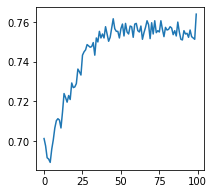

In [ ]:
plt.figure(figsize = (3, 3))
plt.plot(accs0)

AFL

In [ ]:
initial_params = None
learning_rate = 0.01
BATCH_SIZE = 20

In [ ]:
LR_AFL_fit = AFL(train_dataset, IDs, my_LogR, initial_params, learning_rate, lambda_learning_rate=0.01)

In [ ]:
test_datasets = [Client_Data(test_dataset, id) for id in IDs]
accs1 = []
losses = np.arange(6, 0, -1)

In [ ]:
ITER = 1000
for i in range(ITER):
  loss = LR_AFL_fit.train(BATCH_SIZE)
  print('----------iter: {:d}/{:d}, loss: {:f}----------'.format(i+1, ITER, loss))
  losses[:-1] = losses[1:]
  losses[-1] = loss
  if sum(losses[:-1] >= losses[1:]) == 0:
    break
  final_model = LR_AFL_fit.model

  accs = [final_model.predict_error(client_data) for client_data in test_datasets]
  for k, id in enumerate(IDs):
    print('{} dataset prediction accuracy: {:2f}'.format(id, accs[k]*100))
  acc1 = np.mean(accs)
  accs1.append(acc1)
  print('----------iter: {:d}/{:d}, accu: {:f}----------'.format(i+1, ITER, acc1*100))

Streaming output truncated to the last 5000 lines.
Dress dataset prediction accuracy: 75.600000
Coat dataset prediction accuracy: 70.800000
Sandal dataset prediction accuracy: 86.000000
Shirt dataset prediction accuracy: 67.500000
Sneaker dataset prediction accuracy: 76.500000
Bag dataset prediction accuracy: 82.200000
Ankle boot dataset prediction accuracy: 76.600000
----------iter: 584/1000, accu: 75.910000----------
----------iter: 585/1000, loss: 7.100535----------
T-shirt/top dataset prediction accuracy: 72.900000
Trouser dataset prediction accuracy: 77.300000
Pullover dataset prediction accuracy: 71.600000
Dress dataset prediction accuracy: 75.600000
Coat dataset prediction accuracy: 72.400000
Sandal dataset prediction accuracy: 86.200000
Shirt dataset prediction accuracy: 68.200000
Sneaker dataset prediction accuracy: 76.500000
Bag dataset prediction accuracy: 81.700000
Ankle boot dataset prediction accuracy: 76.500000
----------iter: 585/1000, accu: 75.890000----------
--------

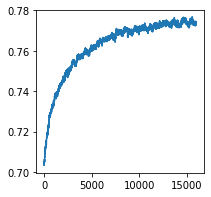

In [ ]:
plt.figure(figsize = (3, 3))
plt.plot(accs1)

qFFL

In [ ]:
initial_params = None
learning_rate = 0.001
q1 = 5
q2 = 15
EPOCH = 1
BATCH_SIZE = 20
LR_qFFL_fit = qFFL(0, 0, train_dataset, IDs, my_LogR, initial_params, learning_rate)

In [ ]:
_,_,grads = LR_qFFL_fit.clients[2].sgd(BATCH_SIZE)

In [ ]:
g1 = np.concatenate(grads).ravel()
w1 = LR_qFFL_fit.clients[0].model.print_params()
w1 = np.concatenate(w1).ravel()

In [ ]:
LR_qFFL_fit = qFFL(0, 0, train_dataset, IDs, my_LogR, initial_params, learning_rate)

In [ ]:
_,_,grads = LR_qFFL_fit.clients[2].sgd(BATCH_SIZE)

In [ ]:
g2 = np.concatenate(grads).ravel()
w2 = LR_qFFL_fit.clients[0].model.print_params()
w2 = np.concatenate(w2).ravel()

In [ ]:
L = np.sqrt(np.sum(np.square(g2 - g1))) / np.sqrt(np.sum(np.square(w2 - w1)))

In [ ]:
L

0.6077197

In [ ]:
initial_params = None
learning_rate = 0.001
q1 = 5
q2 = 15
EPOCH = 1
BATCH_SIZE = 20

In [ ]:
LR_qFFL_fit = qFFL(q1, L, train_dataset, IDs, my_LogR, initial_params, learning_rate)

In [ ]:
test_datasets = [Client_Data(test_dataset, id) for id in IDs]
accs2 = []
losses = np.arange(10, 0, -1, dtype = np.float64)

In [ ]:
ITER = 5000
for i in range(ITER):
  loss = LR_qFFL_fit.train(EPOCH, BATCH_SIZE)
  print('----------iter: {:d}/{:d}, loss: {:f}----------'.format(i+1, ITER, loss))
  losses[:-1] = losses[1:]
  losses[-1] = loss
  if sum(losses[:-1] >= losses[1:]) == 0:
    break
  final_model = LR_qFFL_fit.model

  accs = [final_model.predict_accu(client_data) for client_data in test_datasets]
  for k, id in enumerate(IDs):
    print('{} dataset prediction accuracy: {:2f}'.format(id, accs[k]*100))
  acc2 = np.mean(accs)
  accs2.append(acc2)
  print('----------iter: {:d}/{:d}, accu: {:f}----------'.format(i+1, ITER, acc2*100))

Streaming output truncated to the last 5000 lines.
----------iter: 4001/5000, loss: 0.130711----------
Shirt dataset prediction accuracy: 49.900000
Pullover dataset prediction accuracy: 89.300000
T-shirt/top dataset prediction accuracy: 85.400000
----------iter: 4001/5000, accu: 74.866667----------
----------iter: 4002/5000, loss: 0.129633----------
Shirt dataset prediction accuracy: 59.000000
Pullover dataset prediction accuracy: 86.400000
T-shirt/top dataset prediction accuracy: 81.100000
----------iter: 4002/5000, accu: 75.500000----------
----------iter: 4003/5000, loss: 0.130573----------
Shirt dataset prediction accuracy: 79.700000
Pullover dataset prediction accuracy: 67.700000
T-shirt/top dataset prediction accuracy: 63.900000
----------iter: 4003/5000, accu: 70.433333----------
----------iter: 4004/5000, loss: 0.134195----------
Shirt dataset prediction accuracy: 51.200000
Pullover dataset prediction accuracy: 87.200000
T-shirt/top dataset prediction accuracy: 88.100000
------

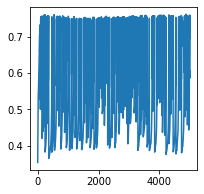

In [ ]:
plt.figure(figsize = (3, 3))
plt.plot(accs2)

## Testing

In [ ]:
final_model = LR_WAVGM_fit.model

FedAvg_accs = [final_model.predict_error(client_data) for client_data in test_datasets]
print(FedAvg_accs)

[0.495, 0.901, 0.479, 0.794, 0.713, 0.665, 0.534, 0.795, 0.848, 0.828]


In [ ]:
final_model = LR_AFL_fit.model

AFL_accs = [final_model.predict_error(client_data) for client_data in test_datasets]
print(AFL_accs)

[0.71, 0.792, 0.71, 0.776, 0.716, 0.866, 0.701, 0.779, 0.824, 0.792]


In [ ]:
final_model = LR_qFFL_fit.model

qFFL_accs = [final_model.predict_accu(client_data) for client_data in test_datasets]
print(qFFL_accs)

[0.032, 0.059, 0.203]


In [ ]:
print(np.std(FedAvg_accs))
print(np.std(AFL_accs))

0.1470019047495644
0.05289461220200033


## Replications

FedAvg

In [ ]:
initial_params = None
learning_rate = 0.001
EPOCH = 1
BATCH_SIZE = 20
ITER = 100

In [ ]:
shirt_test = Client_Data(test_dataset, IDs[0])
pull_test = Client_Data(test_dataset, IDs[1])
tshirt_test = Client_Data(test_dataset, IDs[2])

In [ ]:
REP = 50
Results1 = np.zeros((REP, 3))
for r in range(REP):
  LR_WAVGM_fit = WAVGM(train_dataset, IDs, my_LogR, initial_params, learning_rate)
  for i in range(ITER):
    loss = LR_WAVGM_fit.train(EPOCH, BATCH_SIZE)
    #losses[:-1] = losses[1:]
    #losses[-1] = loss
    #if sum(losses[:-1] >= losses[1:]) == 0:
    #  break
  final_model = LR_WAVGM_fit.model
  acc1 = final_model.predict_error(shirt_test)
  Results1[r, 0] = acc1*100
  acc2 = final_model.predict_error(pull_test)
  Results1[r, 1] = acc2*100
  acc3 = final_model.predict_error(tshirt_test)
  Results1[r, 2] = acc3*100
  print('Shirt prediction accuracy: {:2f} \nPullover data prediction accuracy: {:2f} \nT-shirt/top prediction accuracy: {:2f}'.format(acc1*100, acc2*100, acc3*100))

Shirt prediction accuracy: 62.100000 
Pullover data prediction accuracy: 81.900000 
T-shirt/top prediction accuracy: 82.100000
Shirt prediction accuracy: 62.700000 
Pullover data prediction accuracy: 81.500000 
T-shirt/top prediction accuracy: 80.400000
Shirt prediction accuracy: 65.200000 
Pullover data prediction accuracy: 81.200000 
T-shirt/top prediction accuracy: 81.100000
Shirt prediction accuracy: 63.900000 
Pullover data prediction accuracy: 81.700000 
T-shirt/top prediction accuracy: 82.000000
Shirt prediction accuracy: 63.400000 
Pullover data prediction accuracy: 82.900000 
T-shirt/top prediction accuracy: 81.600000
Shirt prediction accuracy: 63.900000 
Pullover data prediction accuracy: 82.700000 
T-shirt/top prediction accuracy: 81.500000
Shirt prediction accuracy: 63.800000 
Pullover data prediction accuracy: 81.500000 
T-shirt/top prediction accuracy: 82.000000
Shirt prediction accuracy: 64.200000 
Pullover data prediction accuracy: 82.700000 
T-shirt/top prediction accu

In [ ]:
print(Results1)

[[62.1 81.9 82.1]
 [62.7 81.5 80.4]
 [65.2 81.2 81.1]
 [63.9 81.7 82. ]
 [63.4 82.9 81.6]
 [63.9 82.7 81.5]
 [63.8 81.5 82. ]
 [64.2 82.7 80.8]
 [62.5 83.  81. ]
 [63.4 82.4 81.8]
 [64.5 81.1 82.2]
 [63.8 82.1 82.1]
 [62.  80.6 82.4]
 [63.9 81.1 83. ]
 [62.7 81.8 81.9]
 [63.9 81.  81.4]
 [62.5 82.8 82.9]
 [63.7 81.1 81.3]
 [64.5 80.8 80.7]
 [61.6 82.8 82.5]
 [63.5 80.7 81.7]
 [63.4 81.3 81. ]
 [63.4 81.8 82. ]
 [64.  82.1 81.2]
 [63.5 81.4 80.3]
 [63.4 81.5 80.3]
 [65.8 79.4 81. ]
 [61.9 82.8 81.4]
 [63.2 82.6 82.1]
 [62.8 82.8 82.6]
 [63.9 80.6 82.5]
 [64.8 81.3 81.7]
 [64.5 80.7 81.6]
 [64.5 80.9 79.7]
 [62.6 82.3 82.4]
 [63.8 81.1 82.8]
 [64.  80.1 81.6]
 [65.2 81.  81.1]
 [63.8 81.4 81.6]
 [63.1 81.7 80.7]
 [64.3 81.3 81.5]
 [63.5 81.9 82.7]
 [63.  81.9 82.4]
 [65.2 80.1 81.7]
 [61.8 83.2 82.7]
 [61.6 83.4 81. ]
 [61.8 82.2 82.8]
 [64.2 80.1 81.3]
 [63.3 81.8 83.5]
 [64.2 81.1 81.9]]


In [ ]:
Results1.mean(axis = 0)

array([63.524, 81.624, 81.71 ])

In [ ]:
Results1.std(axis = 0)

array([0.98357714, 0.89276201, 0.7925276 ])

In [ ]:
Results1.mean(axis = 1).mean()

75.61933333333333

In [ ]:
Results1.mean(axis = 1).std()

0.3322709737548539

AFL

In [ ]:
initial_params = None
learning_rate = 0.001
BATCH_SIZE = 20
ITER = 10000

In [ ]:
shirt_test = Client_Data(test_dataset, IDs[0])
pull_test = Client_Data(test_dataset, IDs[1])
tshirt_test = Client_Data(test_dataset, IDs[2])

In [ ]:
REP = 50
Results2 = np.zeros((REP, 3))
for r in range(REP):
  LR_AFL_fit = AFL(train_dataset, IDs, my_LogR, initial_params, learning_rate, lambda_learning_rate=0.01)
  for i in range(ITER):
    loss = LR_AFL_fit.train(BATCH_SIZE)
    losses[:-1] = losses[1:]
    losses[-1] = loss
    if sum(losses[:-1] >= losses[1:]) == 0:
      break
  final_model = LR_AFL_fit.model
  acc1 = final_model.predict_error(shirt_test)
  Results2[r, 0] = acc1*100
  acc2 = final_model.predict_error(pull_test)
  Results2[r, 1] = acc2*100
  acc3 = final_model.predict_error(tshirt_test)
  Results2[r, 2] = acc3*100
  print('Shirt prediction accuracy: {:2f} \nPullover data prediction accuracy: {:2f} \nT-shirt/top prediction accuracy: {:2f}'.format(acc1*100, acc2*100, acc3*100))

In [ ]:
print(Results2)

[[75.4 80.  81. ]
 [76.5 79.9 80.7]
 [75.4 80.2 81.6]
 [75.5 80.1 80.2]
 [76.9 79.1 81.1]
 [76.1 79.2 81.3]
 [75.8 78.4 81.2]
 [78.  79.2 79.6]
 [77.6 79.  79.8]
 [77.  79.3 80.2]
 [77.1 80.4 80.6]
 [75.6 80.1 81. ]
 [76.8 79.  80.4]
 [77.1 79.1 80.4]
 [75.4 80.4 81.6]
 [76.4 79.4 81.3]
 [75.8 78.3 81.3]
 [75.4 79.8 81. ]
 [76.2 79.  81.7]
 [76.4 77.8 81.8]
 [76.5 79.5 81.7]
 [76.1 80.4 80.6]
 [76.4 79.4 80.7]
 [75.9 80.5 82.1]
 [75.8 79.  82.1]
 [75.5 79.6 81.4]
 [76.3 79.8 80.5]
 [76.  79.5 81.1]
 [76.4 79.3 80.8]
 [76.8 79.3 80.6]
 [76.2 80.3 80.6]
 [76.2 79.3 81.1]
 [76.4 79.9 81.7]
 [76.4 78.6 80.7]
 [76.6 80.  79.5]
 [75.5 79.  80.9]
 [76.7 78.7 81.8]
 [76.6 79.9 81.5]
 [75.5 81.1 80.9]
 [76.  79.7 80.7]
 [75.7 80.4 81.2]
 [76.9 78.6 80.1]
 [76.3 78.2 81. ]
 [75.9 78.9 81.4]
 [76.5 78.7 81.2]
 [77.5 79.2 80.6]
 [77.  78.8 80.3]
 [75.7 78.6 80.9]
 [75.6 80.3 81.7]
 [77.  79.8 80.2]]


In [ ]:
Results2.mean(axis = 0)

array([76.286, 79.44 , 80.948])

In [ ]:
Results2.std(axis = 0)

array([0.62225718, 0.69598851, 0.60505867])

In [ ]:
Results2.mean(axis = 1).mean()

78.89133333333334

In [ ]:
Results2.mean(axis = 1).std()

0.24942689866527598

qFFL

In [ ]:
initial_params = None
learning_rate = 0.001
BATCH_SIZE = 20
q1 = 5
q2 = 15

In [ ]:
shirt_test = Client_Data(test_dataset, IDs[0])
pull_test = Client_Data(test_dataset, IDs[1])
tshirt_test = Client_Data(test_dataset, IDs[2])

In [ ]:
REP = 10
ITER = 1000
Results3 = np.zeros((REP, 3))
for r in range(REP):
  LR_qFFL_fit = qFFL(q2, L, train_dataset, IDs, my_LogR, initial_params, learning_rate)
  for i in range(ITER):
    loss = LR_qFFL_fit.train(EPOCH, BATCH_SIZE)
    losses[:-1] = losses[1:]
    losses[-1] = loss
    if sum(losses[:-1] >= losses[1:]) == 0:
      break
  final_model = LR_qFFL_fit.model
  acc1 = final_model.predict_accu(shirt_test)
  Results3[r, 0] = acc1*100
  acc2 = final_model.predict_accu(pull_test)
  Results3[r, 1] = acc2*100
  acc3 = final_model.predict_accu(tshirt_test)
  Results3[r, 2] = acc3*100
  print('Shirt prediction accuracy: {:2f} \nPullover data prediction accuracy: {:2f} \nT-shirt/top prediction accuracy: {:2f}'.format(acc1*100, acc2*100, acc3*100))

Shirt prediction accuracy: 73.500000 
Pullover data prediction accuracy: 74.300000 
T-shirt/top prediction accuracy: 70.500000
Shirt prediction accuracy: 73.800000 
Pullover data prediction accuracy: 74.400000 
T-shirt/top prediction accuracy: 70.400000
Shirt prediction accuracy: 73.900000 
Pullover data prediction accuracy: 74.400000 
T-shirt/top prediction accuracy: 70.300000
Shirt prediction accuracy: 73.900000 
Pullover data prediction accuracy: 74.500000 
T-shirt/top prediction accuracy: 70.300000
Shirt prediction accuracy: 73.900000 
Pullover data prediction accuracy: 74.300000 
T-shirt/top prediction accuracy: 70.200000
Shirt prediction accuracy: 73.100000 
Pullover data prediction accuracy: 74.100000 
T-shirt/top prediction accuracy: 70.300000
Shirt prediction accuracy: 74.000000 
Pullover data prediction accuracy: 74.400000 
T-shirt/top prediction accuracy: 70.600000
Shirt prediction accuracy: 73.300000 
Pullover data prediction accuracy: 74.600000 
T-shirt/top prediction accu

In [ ]:
print(Results3)

[[73.5 74.3 70.5]
 [73.8 74.4 70.4]
 [73.9 74.4 70.3]
 [73.9 74.5 70.3]
 [73.9 74.3 70.2]
 [73.1 74.1 70.3]
 [74.  74.4 70.6]
 [73.3 74.6 70.6]
 [72.9 74.3 70.1]
 [73.7 74.8 70.8]]


In [ ]:
Results3.mean(axis = 0)

array([73.6 , 74.41, 70.41])

In [ ]:
Results3.std(axis = 0)

array([0.36331804, 0.18138357, 0.20223748])

In [ ]:
Results3.mean(axis = 1).mean()

72.80666666666666

In [ ]:
Results3.mean(axis = 1).std()

0.19367785395112222